In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import time

In [2]:
train_dir = './train'
test_dir = './test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [3]:
class cats_vs_dogs_dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,dir,train=True,transform=None):
        self.file_list = file_list
        self.dir = dir
        self.train = train
        self.transform = transform
        if self.train:
            if 'dog' in self.file_list[0]:
                self.label=1
            else:
                self.label=0
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.train:
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

In [4]:
cat_files = [f for f in train_files if 'cat' in f]
dog_files = [f for f in train_files if 'dog' in f]

In [5]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

In [6]:
cats = cats_vs_dogs_dataset(cat_files,train_dir,transform=data_transform)
dogs = cats_vs_dogs_dataset(dog_files,train_dir,transform=data_transform)

In [7]:
train_data = torch.utils.data.ConcatDataset([cats,dogs])

In [8]:
len(train_data)

25000

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 50, shuffle=True, num_workers=4)

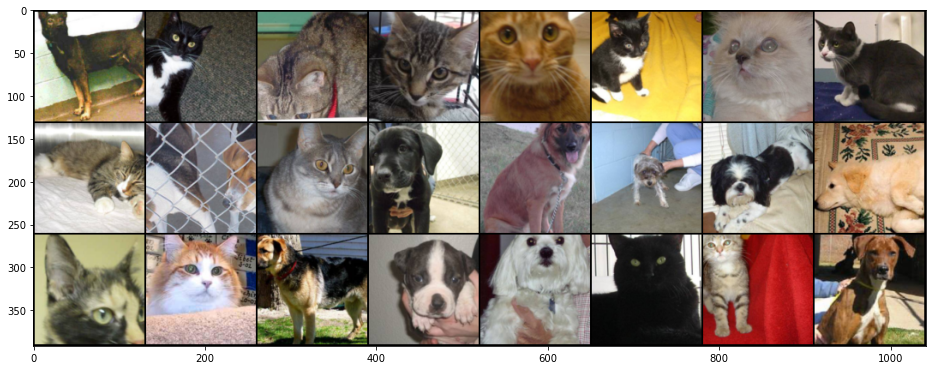

In [10]:
sample,label = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_img = torchvision.utils.make_grid(sample[:24])
np_grid_img = grid_img.numpy()
plt.imshow(np.transpose(np_grid_img,(1,2,0)))

In [11]:
sample.shape

torch.Size([50, 3, 128, 128])

In [12]:
def get_device():
    if torch.cuda.is_available():
        device='cuda:0'
    else:
        device='cpu'
    return device
device = get_device()

In [13]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        out1 = 12
        out2 = 32
        out3 = 64
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=out1,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=out1,out_channels=out1,kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=out1,out_channels=out2,kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=out2,out_channels=out2,kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=out2,out_channels=out3,kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=out3,out_channels=out3,kernel_size=3)

        self.lin1 = nn.Linear(in_features=out3*12*12,out_features=864)
        self.lin2 = nn.Linear(in_features=864,out_features=216)
        self.lin3 = nn.Linear(in_features=216,out_features=54)
        self.out = nn.Linear(in_features=54,out_features=2)

    def forward(self,x):
        out3 = 64
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x,kernel_size=2,stride=2)

        x = F.relu(self.lin1(x.reshape(-1,out3*12*12)))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = F.sigmoid(self.out(x))
        return x

In [14]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [15]:
model = Network()

In [16]:
epochs = 50
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
loss_list = []
acc_list = []

In [17]:
model.to(device)
for epoch in range(epochs):
    total_loss = 0.0
    accuracy = 0.0
    start=time.time()
    for samples,labels in train_loader:
        samples,labels = samples.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()

        total_loss+=loss
        accuracy += output.argmax(dim=1).eq(labels).sum().item()
        loss_list.append(total_loss)
        acc_list.append(accuracy)
    print('Epoch: {}\t Loss: {:.6f}\tAcc: {:.3f}\t batch time: {:.3f}'.format(epoch,total_loss,accuracy/len(train_data),time.time()-start))
model.to('cpu')


/home/adam/anaconda3/envs/xai/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0	 Loss: 346.616455	Acc: 0.497	 batch time: 23.899
Epoch: 1	 Loss: 346.592346	Acc: 0.496	 batch time: 22.123
Epoch: 2	 Loss: 346.600342	Acc: 0.493	 batch time: 22.258
Epoch: 3	 Loss: 346.588165	Acc: 0.498	 batch time: 22.297


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(),'cat_dog_model.pt')
name = 'cat_dog_model.onnx'
torch.onnx.export(model,sample,name,verbose=True)

In [ ]:
plt.plot(acc_list)

In [78]:
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = cats_vs_dogs_dataset(test_files, test_dir, train=False, transform = test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle=False, num_workers=4)

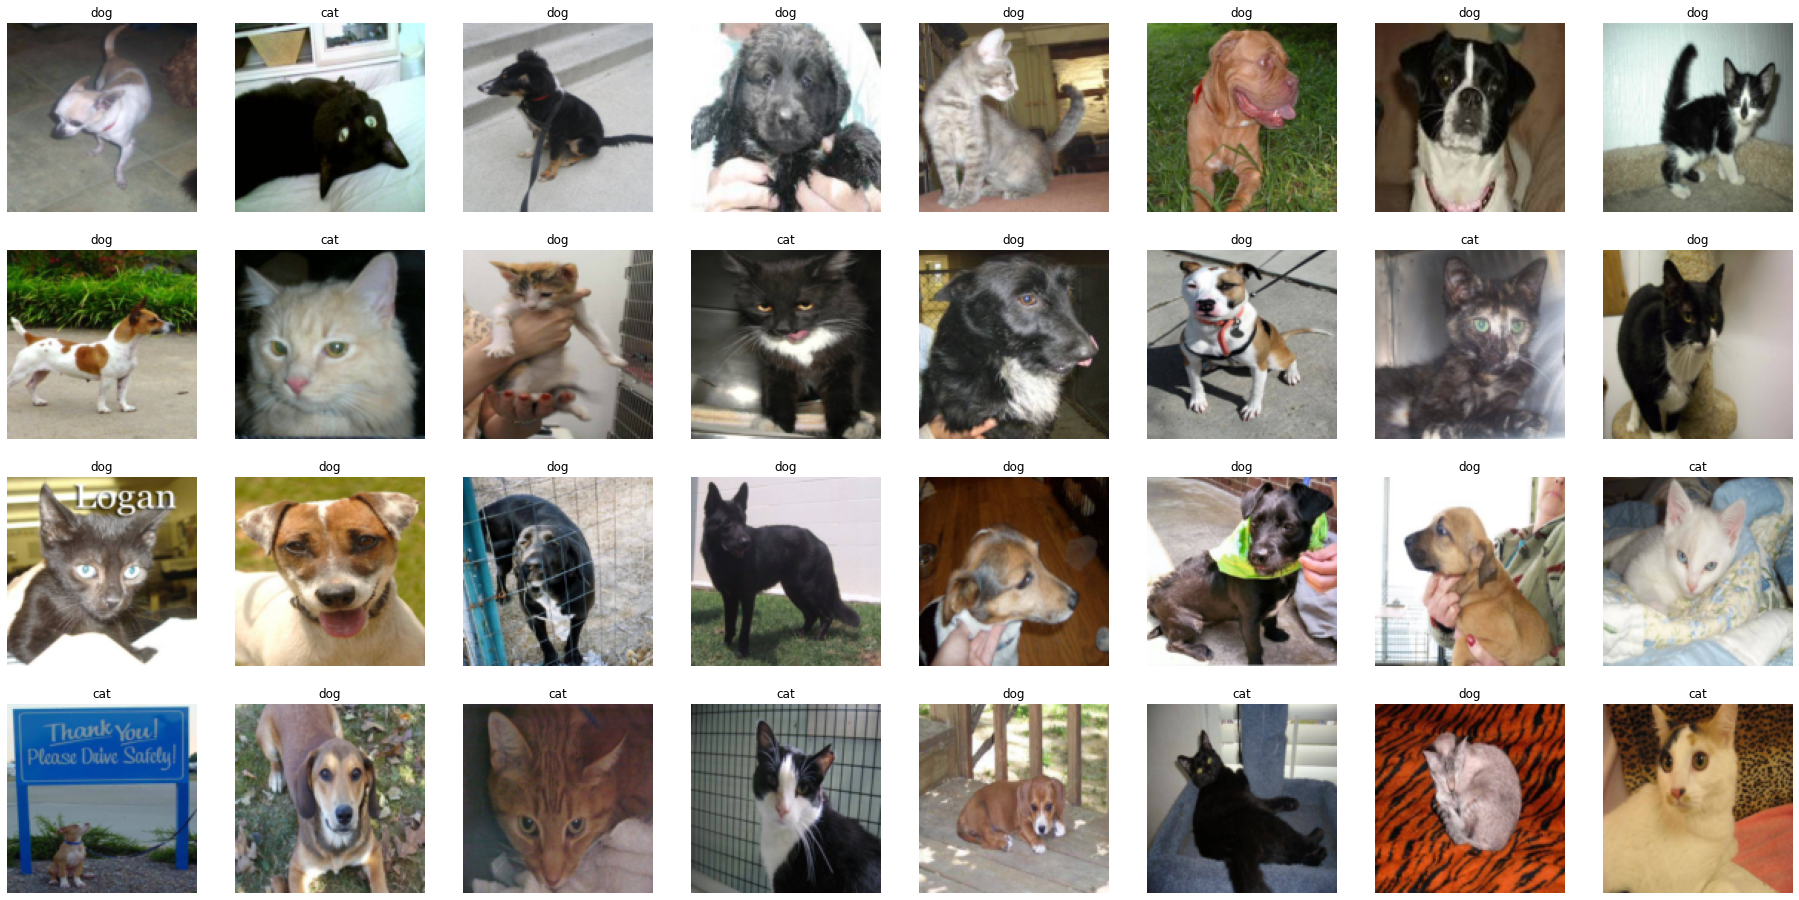

In [88]:
samples, _ = iter(testloader).next()
samples = samples
fig = plt.figure(figsize=(32, 16))
fig.tight_layout()
output = model(samples[:32])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:32]):
    plt.subplot(4,8,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

In [104]:
def get_accuracy(model,train_loader):
    acc = 0
    for samples, labels in train_loader:
        preds = model(samples)
        acc += get_num_correct(preds,labels)
    return acc    

In [105]:
acc /= len(train_data)
acc

0.90492

In [89]:
import umap

In [132]:
umap_loader = torch.utils.data.DataLoader(train_data, batch_size = 1, shuffle=True, num_workers=4)

In [135]:
img,target = iter(umap_loader).next()
img.shape

torch.Size([1, 3, 128, 128])

In [138]:
samples_shape = list(sample.shape)
data_shape = [len(train_data)]
for i in samples_shape:
    data_shape.append(i)

data = np.empty((data_shape[0],data_shape[2],data_shape[3],data_shape[4])).reshape(data_shape[0],-1)
targets = np.empty((len(train_data)))

for idx,(sample, label) in  enumerate(umap_loader):
    data[idx] =sample.numpy().flatten()

(25000, 49152)